# Mongolia 

In [3]:
import sys
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import rasterio as rio
from rasterio.mask import mask
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from glob import glob

import os
from glob import glob
import matplotlib.pyplot as plt
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep


import matplotlib.pyplot as plt
# %matplotlib inline

import utils
import util_preprocess

## Set directories here

In [1]:
# Get abosolute path of the current folder
FPATH = 'D:/mongolia/GITHUB/features'

# Get abosolute output path of te current folder
OUTPUT = 'D:/mongolia/mongolia_ml_model/output/'

target = 'class'

# Random seed
# The random seed
random_seed = 42

# Set random seed in numpy
import numpy as np
np.random.seed(random_seed)

## Stack SpFea in VRT

In [2]:
# Load data to VRT for processing 
files = sorted(glob(f'{FPATH}/*/*.tif'))
# print(files)

# vrt_options = gdal.BuildVRTOptions(separate=True)
# vrt =  gdal.BuildVRT(f'{OUTPUT}/data_output/mgl_spfea.vrt', files, options=vrt_options)
# vrt = None

NameError: name 'glob' is not defined

## Load VRT and read to array 

In [5]:
# PATH= 'D:/mongolia/mongolia_ml_model/output/data_output/mgl_spfea.vrt'
# img = utils.read_image(PATH)
# img_arr=img[0]
# img_gt=img[1]
# img_georef=img[2]

# # Process spfea features, get the width, height and number of bands
# n = img_arr.shape[0]
# print (n) # number of bands
# h = img_arr.shape[1]
# print (h) # height
# w = img_arr.shape[2]
# print (w) # width

# Load data to VRT for processing 
# files = sorted(glob(f'{FPATH}/fourier/*.tif'))
array_stack, meta_data = es.stack(files, nodata=0.0)

# Process spfea features, get the width, height and number of bands
n = array_stack.shape[0]
print (n) # number of bands
h = array_stack.shape[1]
print (h) # height
w = array_stack.shape[2]
print (w) # width

138
2379
2490


In [6]:
array_stack.shape

(138, 2379, 2490)

## Plot images

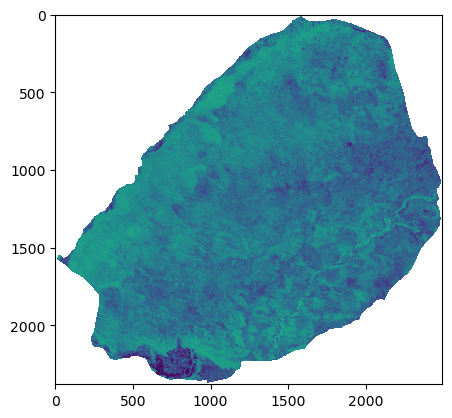

In [7]:
#plot 
plt.imshow(array_stack[9])

## Loading and processind training dataset

In [14]:
PATH_TR=glob(f'D:/mongolia/mongolia_ml_model/train_mgl_2/*.tif')

# files = sorted(glob(f'{FPATH}/*/*.tif'))
# files = sorted(glob(f'{FPATH}/fourier/*.tif'))
train_array, meta_data = es.stack(PATH_TR, nodata=-2147483648)
train_array = train_array.astype(int)
# Tr = rio.open(PATH_TR)
# data_loc = Tr.read()
# data_loc = np.array(data_loc)
# data_loc = data_loc.astype(int)
#Print data shape
print(train_array.shape)

(unique, counts) = np.unique(train_array, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

(2, 2379, 2490)


array([[-2147483648,    11843450],
       [          1,         626],
       [          2,         294],
       [          3,         110],
       [          4,         284],
       [          5,         446],
       [          6,        1098],
       [          7,         986],
       [          8,         126]], dtype=int64)

## Concatenate training and features  dataset

In [16]:
# concat 
y=np.array(train_array[0,...]).reshape(1,h,w)
x=array_stack
data = np.concatenate((y,x),axis=0)
data.shape

(139, 2379, 2490)

## Spliting data train, validationa and test 



In [17]:
# We now split our data into training and test set
data = data.reshape(data.shape[0], -1)
#Train data
# data_train = data[:, ~np.isnan(data).any(axis=0)]
#data_train = data_train[:, (data_train!=-999).any(axis=0)]
data_train = data[:, data[0,...]!=-2147483648]
y = data_train[0,...]
x = data_train[1:,...]
#Test data
#data_test = data[:, np.isnan(data).any(axis=0)]
#data_test = data_test[:, (data_test==-999).any(axis=0)]
#data_test = data_test[:,  data_test[0,...]==-999]
#y_test = data_test[0,...]
#x_test = data_test[1:,...]
#Let's check the shape
print(data_train.shape)
#print(data_test.shape)

(unique, counts) = np.unique(y, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

print (x.shape)
print (y.shape)

(139, 1985)
(138, 1985)
(1985,)


In [18]:
# Split into train / test data.
from sklearn.model_selection import train_test_split
test_size = 0.2
x = np.transpose(x)
y = np.transpose(y)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=test_size, random_state = random_seed) # stratify = y)

x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=test_size,  random_state = random_seed) #, stratify = y)

X_train = x_train
X_val = x_val
X_test = x_test

## Standardization 

In [10]:
# from sklearn.preprocessing import StandardScaler

# # The StandardScaler
# ss = StandardScaler()
# # Standardize the training data
# X_train = ss.fit_transform(x_train)

# # Standardize the validation data
# X_val = ss.transform(x_val)

# # Standardize the test data
# X_test = ss.transform(x_test)

In [11]:
from sklearn.utils import shuffle
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler

In [83]:
# x = np.transpose(x)
# y = np.transpose(y)

# print(x.shape)
# print (y.shape)

# groups = np.arange(start=0,stop = len(y), dtype=int)
# n_splits = 2
# x_shuffled, y_shuffled, groups_shuffled = shuffle(x, y, groups, random_state=42)
# group_kfold = GroupKFold(n_splits=n_splits)
# group_kfold.get_n_splits(x_shuffled, y_shuffled, groups_shuffled)
# print(group_kfold)

(1985, 138)
(1985,)
GroupKFold(n_splits=2)


In [85]:
# for fold,(train_index, test_index) in enumerate(group_kfold.split(x_shuffled, y_shuffled, groups_shuffled)):

#     train = x[train_index, :]
#     test = x[test_index, :]

#     # 80:20 training:validation inner loop split
#     inner_split_point = int(0.99 * len(train_index))
#     valid_index = train_index[inner_split_point:]
#     train_index = train_index[:inner_split_point]

#     # print(f"Split {fold + 1}")
#     # print("TRAIN:", train_index, "VALID:", valid_index, "TEST:", test_index)
#     X_train, X_val, X_test = x[train_index], x[valid_index], x[test_index]
#     y_train, y_val, y_test = y[train_index], y[valid_index], y[test_index]

#     # Standardize Features for training and test set
#     # The StandardScaler
#     ss = StandardScaler()
#     # Standardize the training data
#     X_train = ss.fit_transform(X_train)
#     X_train_scaled = X_train
#     # Standardize Validation data
#     X_val = ss.fit_transform(X_val)
#     X_val_scaled = X_val
#     # Standardize Testing data
#     X_test = ss.fit_transform(X_test)
#     X_test_scaled = X_test
#     # Check shape of split data
#     print('There are', X_train_scaled.shape[0], 'rows in the train data')
#     print('There are', X_val_scaled.shape[0], 'rows in the validation data')
#     print('There are', X_test_scaled.shape[0], 'rows in the test data')

There are 982 rows in the train data
There are 10 rows in the validation data
There are 993 rows in the test data
There are 983 rows in the train data
There are 10 rows in the validation data
There are 992 rows in the test data


In [81]:
x.shape

(2490, 2379, 138)

## Modeling 

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# model_rf = RandomForestClassifier(max_features='sqrt', n_estimators=100, class_weight="balanced", random_state=random_seed)
model_rf1 = RandomForestClassifier(n_estimators=200, max_depth=2000, max_features='sqrt', min_samples_split=3, class_weight="balanced", random_state=random_seed)

model_rf1.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=2000,
                       min_samples_split=3, n_estimators=200, random_state=42)

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

pred = model_rf1.predict(x_test)
mgl_test = accuracy_score(y_test, pred)
print(("Test accuracy: %f") % (mgl_test))
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, pred))

Test accuracy: 0.987406
=== Confusion Matrix ===
[[ 66   0   0   0   0   0   0   0]
 [  0  30   0   0   0   0   0   0]
 [  0   2  10   0   0   0   0   0]
 [  0   0   0  25   0   0   0   2]
 [  0   0   0   0  42   0   0   0]
 [  0   0   0   0   1 106   0   0]
 [  0   0   0   0   0   0 101   0]
 [  0   0   0   0   0   0   0  12]]


=== Classification Report ===
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        66
         2.0       0.94      1.00      0.97        30
         3.0       1.00      0.83      0.91        12
         4.0       1.00      0.93      0.96        27
         5.0       0.98      1.00      0.99        42
         6.0       1.00      0.99      1.00       107
         7.0       1.00      1.00      1.00       101
         8.0       0.86      1.00      0.92        12

    accuracy                           0.99       397
   macro avg       0.97      0.97      0.97       397
weighted avg       0.99      0.99      0.9

gabor_sc200_filter_10        0.038915
hog_sc200_kurtosis           0.035889
lbpm_sc200_max               0.032300
lbpm_sc200_variance          0.030225
gabor_sc200_filter_12        0.029655
                               ...   
lbpm_sc200_skew              0.000000
lbpm_sc40_mean               0.000000
hog_sc200_mean               0.000000
sfs_sc200_min_line_length    0.000000
hog_sc40_mean                0.000000
Length: 138, dtype: float64


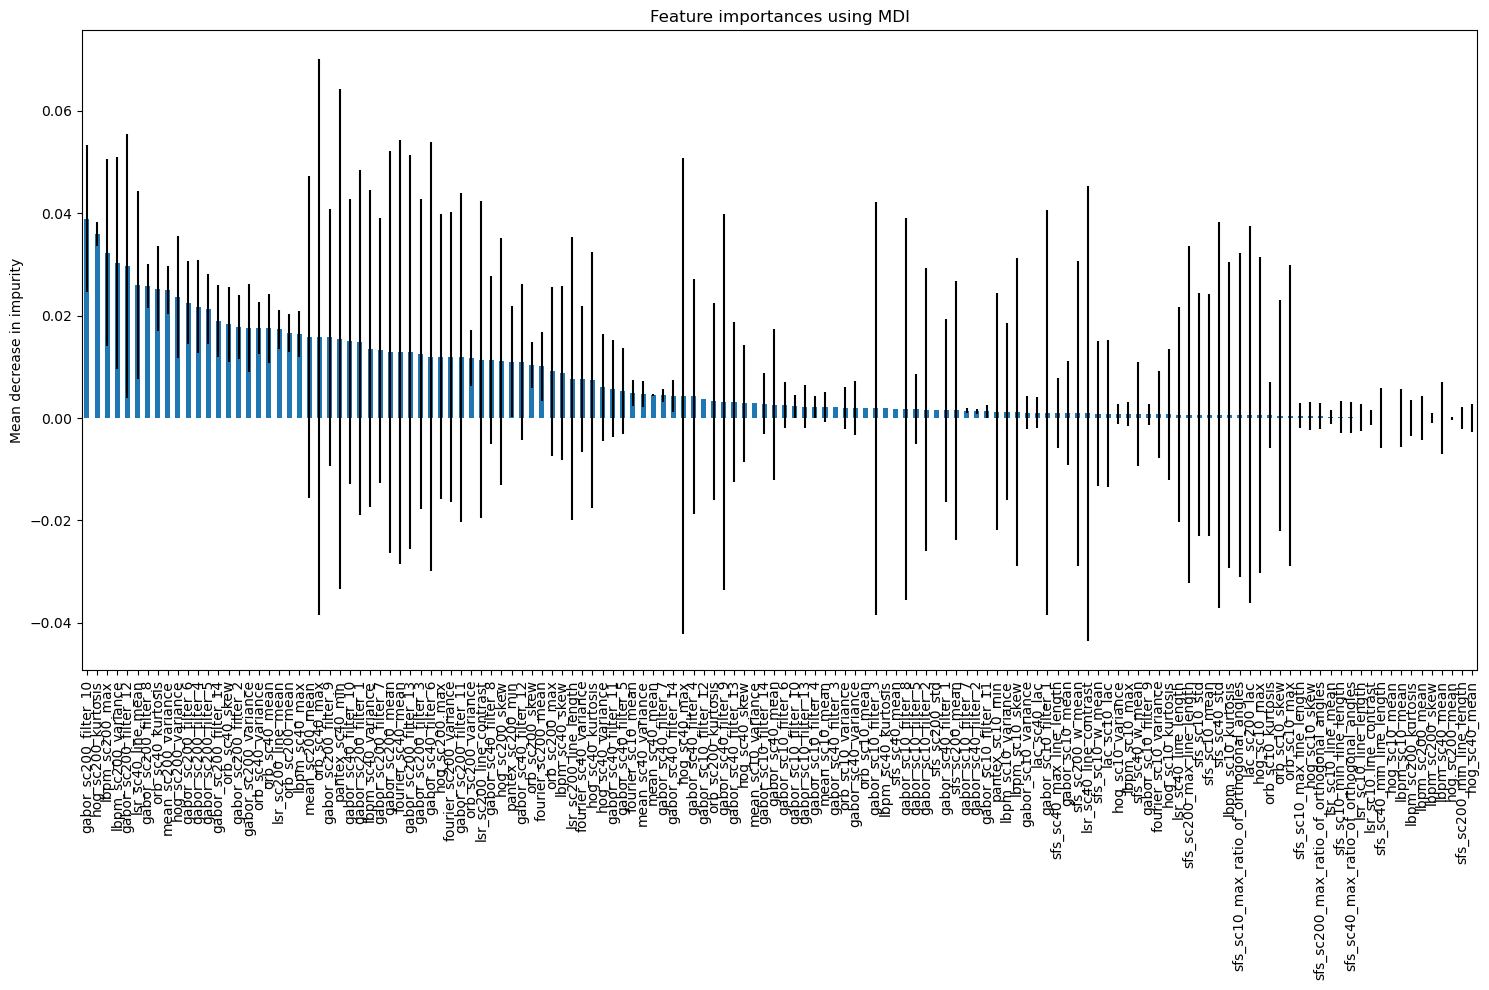

In [21]:
# Feature of importance
# Get band names
bandname = []
for file in files:
    head, tail = os.path.split(file)
    col_names=tail[:-4]
    bandname.append(col_names)

filename_list = bandname
importances = model_rf1.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf1.estimators_], axis=0)

import pandas as pd
forest_importances = pd.Series(importances, index=filename_list).sort_values(ascending=False)
print(forest_importances)

fig, ax = plt.subplots(figsize = (15,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## make prediction

In [1]:
# # missing data
# PATH= 'D:/mongolia/mongolia_ml_model/output/data_output/mgl_spfea.vrt'
# data_all = rio.open(PATH)
# print ('nodata:', data_all.nodata)
# data = data_all.read()
# data = np.ma.masked_array(data, mask=(data==data_all.nodata))
# data.shape

# Load data to VRT for processing 
# files = sorted(glob(f'{FPATH}/fourier/*.tif'))
# array_stack, meta_data = es.stack(files, nodata=0.0)

NameError: name 'rio' is not defined

In [25]:
array_stack, meta_data = es.stack(files, nodata=0.0)
# Make predition 
data = array_stack.reshape(array_stack.shape[0], -1)
# data.shape
# data = ss.fit_transform(data)
map_x = np.transpose(data[0:,...])
# map_x.shape
# map_x = np.nan_to_num(map_x)
pred_map = model_rf1.predict(map_x)
pred_map = pred_map.reshape(h, w)

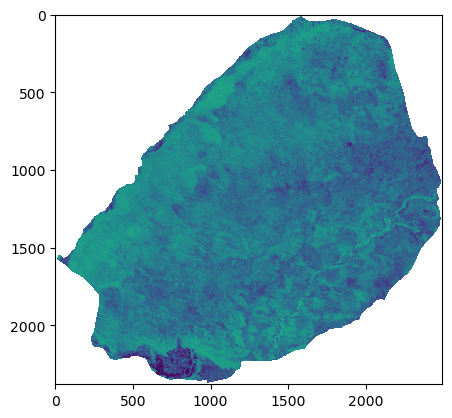

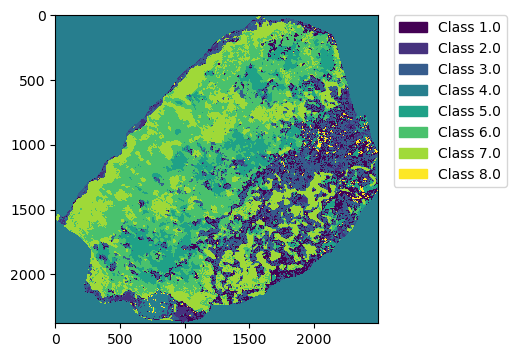

In [26]:
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches

plt.imshow(array_stack[9])

values = np.unique(pred_map.ravel())

plt.figure(figsize=(8,4))
im = plt.imshow(pred_map, interpolation='none')

# get the colors of the values, according to the 
# colormap used by imshow
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="Class {l}".format(l=values[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.show()

## Hyperparameter Tuning

In [23]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


models = {
          'mlpc': MLPClassifier(early_stopping=True, random_state=random_seed),
          'rfc': RandomForestClassifier(class_weight="balanced", random_state=random_seed),
          'gbc': GradientBoostingClassifier(random_state=random_seed)}

In [24]:
from sklearn.pipeline import Pipeline

pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

In [28]:
X_train_val, y_train_val, ps = util_preprocess.get_train_val_ps(X_train, y_train, X_val, y_val)

In [29]:
print(X_train_val.shape)
print(y_train_val.shape)
ps

(1588, 138)
(1588,)


PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0]))

In [30]:
param_grids = {}

# MLP

# The grids for alpha
alpha_grids = [10 ** i for i in range(-5, -2)]

# The grids for learning_rate_init
learning_rate_init_grids = [10 ** i for i in range(-4, -1)]

# Update param_grids
param_grids['mlpc'] = [{'model__alpha': alpha_grids,
                        'model__learning_rate_init': learning_rate_init_grids}]


# Random forest 

# The parameter grid 

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
min_samples_leaf = [1,2,3]
max_features = ['log2', 'sqrt']

# Update param_grids
param_grids['rfc'] = [{'model__n_estimators': n_estimators,
                    'model__min_samples_leaf': min_samples_leaf,
                    'model__max_features':max_features}]


# Gradient boosting 

# The parameter grid of tol
tol_grid = [10 ** -5, 10 ** -4, 10 ** -3]

n_estimators=[int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]

# Update param_grids
param_grids['gbc'] = [{'model__tol': tol_grid,
                      'model__n_estimators': n_estimators}]

In [31]:
# Creating the directory for the cv results produced by GridSearchCV
# Make directory
directory = os.path.dirname('D:/mongolia/mongolia_ml_model/output/mgl_map')
if not os.path.exists(directory):
    os.makedirs(directory)

In [32]:
from sklearn.model_selection import GridSearchCV

# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_params_estimator_gs = []

# For each model
for acronym in pipes.keys():
    # GridSearchCV
    gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='f1_macro',
                      n_jobs=-2,
                      cv=ps,
                      return_train_score=True)
        
    # Fit the pipeline
    gs = gs.fit(X_train_val, y_train_val)
    
    # Update best_score_params_estimator_gs
    best_score_params_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
    # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
    # Get the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score', 
                         'std_test_score', 
                         'mean_train_score', 
                         'std_train_score',
                         'mean_fit_time', 
                         'std_fit_time',                        
                         'mean_score_time', 
                         'std_score_time']
    
    # Move the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

    # Write cv_results file
    cv_results.to_csv(path_or_buf='D:/mongolia/mongolia_ml_model/output/GridSearch' + acronym + '.csv', index=False)

# Sort best_score_params_estimator_gs in descending order of the best_score_
best_score_params_estimator_gs = sorted(best_score_params_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_params_estimator_gs
pd.DataFrame(best_score_params_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

,best_score,best_param,best_estimator
0,1.00000,"{'model__max_features': 'log2', 'model__min_sa...","((DecisionTreeClassifier(max_features='log2', ..."
1,0.98876,"{'model__n_estimators': 200, 'model__tol': 1e-05}",(([DecisionTreeRegressor(criterion='friedman_m...
2,0.30721,"{'model__alpha': 0.0001, 'model__learning_rate...","(MLPClassifier(early_stopping=True, random_sta..."


## modeling

## Model selection 

In [55]:

# Get the best_score, best_params and best_estimator obtained by GridSearchCV
best_score_gs, best_params_gs, best_estimator_gs = best_score_params_estimator_gs[0]
best_params_gs

{'model__max_features': 'log2',
 'model__min_samples_leaf': 1,
 'model__n_estimators': 377}

# Generating the Submission File

In [56]:
# Make directory
directory = os.path.dirname('D:/mongolia/mongolia_ml_model/output/submission/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [57]:
# Get the prediction on the test data using the best model
y_test_pred = best_estimator_gs.predict(X_test)

In [58]:
from sklearn.metrics import classification_report, confusion_matrix


print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_test_pred))

=== Confusion Matrix ===
[[ 66   0   0   0   0   0   0   0]
 [  0  30   0   0   0   0   0   0]
 [  0   2  10   0   0   0   0   0]
 [  0   0   0  27   0   0   0   0]
 [  0   0   0   0  42   0   0   0]
 [  0   0   0   0   0 107   0   0]
 [  0   0   0   0   0   0 101   0]
 [  0   0   0   0   0   0   0  12]]


=== Classification Report ===
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        66
         2.0       0.94      1.00      0.97        30
         3.0       1.00      0.83      0.91        12
         4.0       1.00      1.00      1.00        27
         5.0       1.00      1.00      1.00        42
         6.0       1.00      1.00      1.00       107
         7.0       1.00      1.00      1.00       101
         8.0       1.00      1.00      1.00        12

    accuracy                           0.99       397
   macro avg       0.99      0.98      0.98       397
weighted avg       1.00      0.99      0.99       397



## Inference

In [59]:
# missing data
PATH= 'D:/mongolia/mongolia_ml_model/output/data_output/mgl_spfea.vrt'
data_all = rio.open(PATH)
print ('nodata:', data_all.nodata)
data = data_all.read()
data = np.ma.masked_array(data, mask=(data==data_all.nodata))

# Make predition 
data = data.reshape(data.shape[0], -1)
# data.shape
# data = ss.fit_transform(data)
map_x = np.transpose(data[0:,...])
# map_x.shape
# map_x = np.nan_to_num(map_x)
pred_map = best_estimator_gs.predict(map_x)
pred_map = pred_map.reshape(h, w)




nodata: 0.0


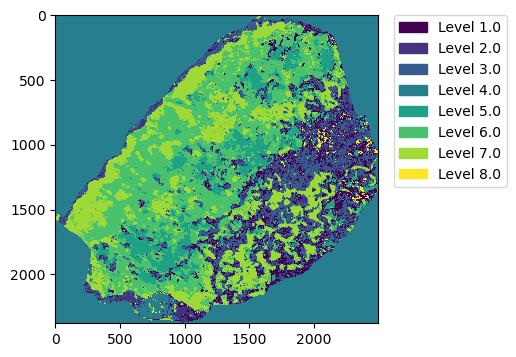

In [60]:
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches

values = np.unique(pred_map.ravel())

plt.figure(figsize=(8,4))
im = plt.imshow(pred_map, interpolation='none')

# get the colors of the values, according to the 
# colormap used by imshow
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.show()

In [61]:
# Creating the directory for the cv results produced by GridSearchCV
# Make directory
directory = os.path.dirname('D:/mongolia/mongolia_ml_model/output/mgl_map')
if not os.path.exists(directory):
    os.makedirs(directory)

In [62]:
import datetime

T = datetime.datetime.now()
time = T.strftime("%y%m%d%H%M%S")

filename = 'mgl'
out_file = f"{directory}/{filename}_{time}_RF_unscale.tif"
# out_file = "/home/ubuntu/max/output/lag_lgb_map.tif"
# update profile from red band
fp = f'D:/mongolia/mongolia_ml_model/features/fourier/fourier_sc10_mean.tif'
with rio.open(fp, mode="r") as src:
    out_profile = src.profile.copy()
    out_profile.update(count=1,
                       nodata=-9999,
                       dtype='float32',
                       width=src.width,
                       height=src.height,
                       crs=src.crs)

# open in 'write' mode, unpack profile info to dst
with rio.open(out_file,
                   'w', **out_profile) as dst:
    dst.write_band(1, pred_map)

## XGBoost

In [39]:
# Get the best_score, best_params and best_estimator obtained by GridSearchCV
best_score_gs, best_params_gs, best_estimator_gs = best_score_params_estimator_gs[1]

# Get the prediction on the test data using the best model
y_test_pred = best_estimator_gs.predict(X_test)

In [40]:
from sklearn.metrics import classification_report, confusion_matrix


print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_test_pred))

=== Confusion Matrix ===
[[ 66   0   0   0   0   0   0   0]
 [  0  29   1   0   0   0   0   0]
 [  0   2  10   0   0   0   0   0]
 [  0   0   0  25   0   0   0   2]
 [  0   0   0   0  42   0   0   0]
 [  0   0   0   0   0 107   0   0]
 [  0   0   0   0   0   0 101   0]
 [  0   0   0   0   0   0   0  12]]


=== Classification Report ===
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        66
         2.0       0.94      0.97      0.95        30
         3.0       0.91      0.83      0.87        12
         4.0       1.00      0.93      0.96        27
         5.0       1.00      1.00      1.00        42
         6.0       1.00      1.00      1.00       107
         7.0       1.00      1.00      1.00       101
         8.0       0.86      1.00      0.92        12

    accuracy                           0.99       397
   macro avg       0.96      0.97      0.96       397
weighted avg       0.99      0.99      0.99       397



In [41]:
# missing data
PATH= 'D:/mongolia/mongolia_ml_model/output/data_output/mgl_spfea.vrt'
data_all = rio.open(PATH)
print ('nodata:', data_all.nodata)
data = data_all.read()
print( "all data", data.shape)
data = np.ma.masked_array(data, mask=(data==data_all.nodata))
print ("masked:", data.shape)
# Make predition 
data = data.reshape(data.shape[0], -1)
# data.shape
# data = ss.fit_transform(data)
map_x = np.transpose(data[0:,...])
# map_x.shape
# map_x = np.nan_to_num(map_x)
pred_map = best_estimator_gs.predict(map_x)
pred_map = pred_map.reshape(h, w)

nodata: 0.0
all data (138, 2379, 2490)
masked: (138, 2379, 2490)


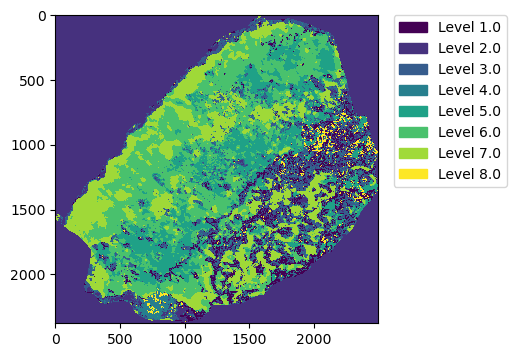

In [42]:
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches

values = np.unique(pred_map.ravel())

plt.figure(figsize=(8,4))
im = plt.imshow(pred_map, interpolation='none')

# get the colors of the values, according to the 
# colormap used by imshow
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.show()

## MLP

In [43]:
# Get the best_score, best_params and best_estimator obtained by GridSearchCV
best_score_gs, best_params_gs, best_estimator_gs = best_score_params_estimator_gs[2]

# Get the prediction on the test data using the best model
y_test_pred = best_estimator_gs.predict(X_test)

In [44]:
from sklearn.metrics import classification_report, confusion_matrix


print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_test_pred))

=== Confusion Matrix ===
[[18  6  3  0  6 24  9  0]
 [ 6 12  3  0  1  6  2  0]
 [ 3  5  0  0  0  3  0  1]
 [ 9  5  0  0  3  9  1  0]
 [ 6  8  0  1  9 17  1  0]
 [ 0  0  0  0 19 58 30  0]
 [ 4  3  0  0  7 38 49  0]
 [ 4  1  2  0  1  1  1  2]]


=== Classification Report ===
              precision    recall  f1-score   support

         1.0       0.36      0.27      0.31        66
         2.0       0.30      0.40      0.34        30
         3.0       0.00      0.00      0.00        12
         4.0       0.00      0.00      0.00        27
         5.0       0.20      0.21      0.20        42
         6.0       0.37      0.54      0.44       107
         7.0       0.53      0.49      0.51       101
         8.0       0.67      0.17      0.27        12

    accuracy                           0.37       397
   macro avg       0.30      0.26      0.26       397
weighted avg       0.36      0.37      0.35       397



In [45]:
# missing data
PATH= 'D:/mongolia/mongolia_ml_model/output/data_output/mgl_spfea.vrt'
data_all = rio.open(PATH)
print ('nodata:', data_all.nodata)
data = data_all.read()
data = np.ma.masked_array(data, mask=(data==data_all.nodata))

# Make predition 
data = data.reshape(data.shape[0], -1)
# data.shape
# data = ss.fit_transform(data)
map_x = np.transpose(data[0:,...])
# map_x.shape
# map_x = np.nan_to_num(map_x)
pred_map = best_estimator_gs.predict(map_x)
pred_map = pred_map.reshape(h, w)

nodata: 0.0


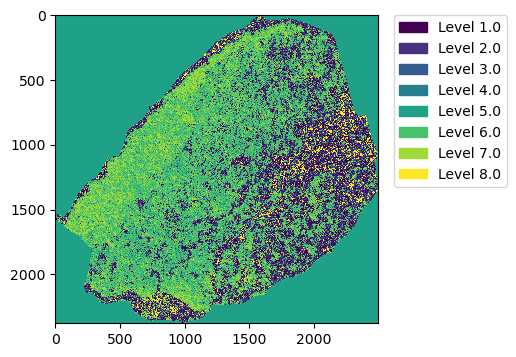

In [46]:
# plt.imshow(pred_map, interpolation='nearest')

values = np.unique(pred_map.ravel())

plt.figure(figsize=(8,4))
im = plt.imshow(pred_map, interpolation='none')

# get the colors of the values, according to the 
# colormap used by imshow
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.show()

In [47]:
# Creating the directory for the cv results produced by GridSearchCV
# Make directory
directory = os.path.dirname('D:/mongolia/mongolia_ml_model/output/mgl_map')
if not os.path.exists(directory):
    os.makedirs(directory)

In [49]:
import datetime

T = datetime.datetime.now()
time = T.strftime("%y%m%d%H%M%S")

filename = 'mgl'
out_file = f"{directory}/{filename}_{time}_MLP_unscale.tif"
# out_file = "/home/ubuntu/max/output/lag_lgb_map.tif"
# update profile from red band
fp = f'D:/mongolia/mongolia_ml_model/features/fourier/fourier_sc10_mean.tif'
with rio.open(fp, mode="r") as src:
    out_profile = src.profile.copy()
    out_profile.update(count=1,
                       nodata=-9999,
                       dtype='float32',
                       width=src.width,
                       height=src.height,
                       crs=src.crs)

# open in 'write' mode, unpack profile info to dst
with rio.open(out_file,
                   'w', **out_profile) as dst:
    dst.write_band(1, pred_map)

# End 

In [63]:
import os
from glob import glob
import matplotlib.pyplot as plt
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

In [137]:
# PATH= 'D:/mongolia/mongolia_ml_model/output/data_output/mgl_spfea.vrt'
# Load data to VRT for processing 
files = sorted(glob(f'{FPATH}/fourier/*.tif'))
array_stack, meta_data = es.stack(files, nodata=0.0)

In [123]:
# bandname

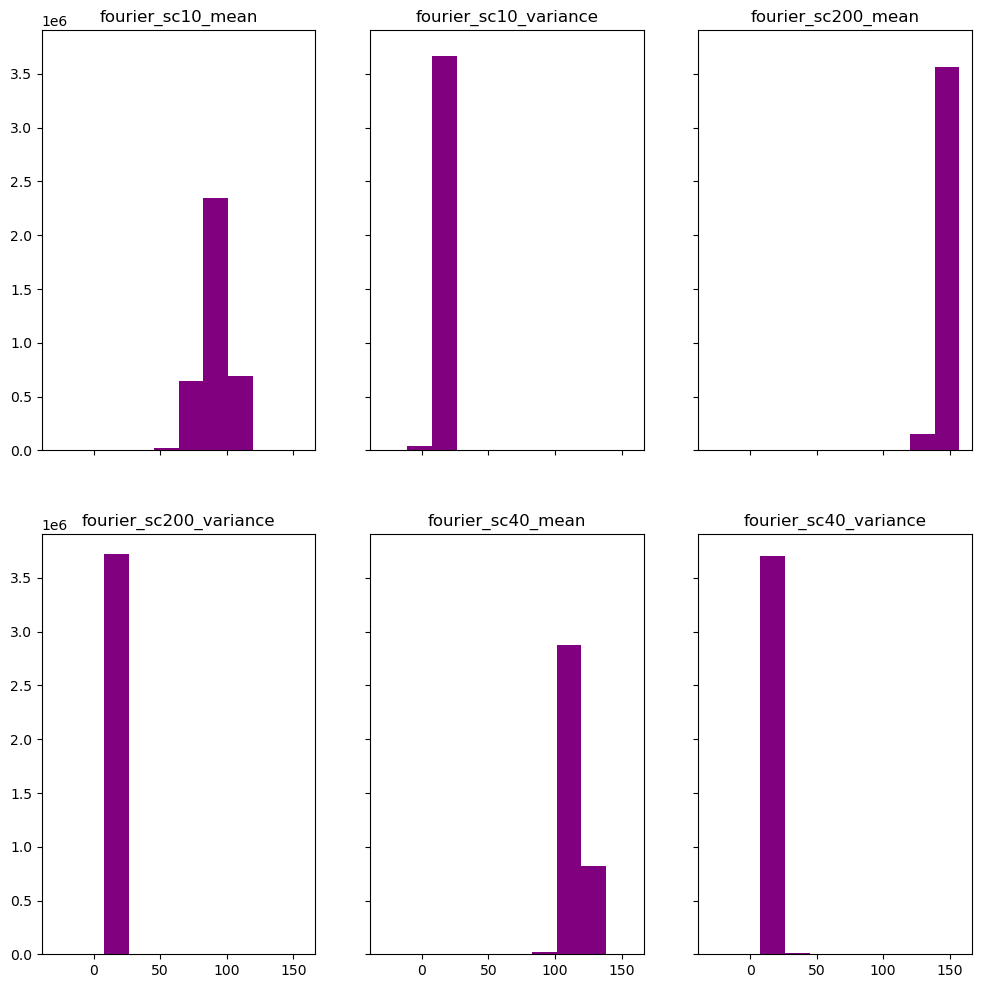

In [138]:
# Create the list of titles for each band. The titles and colors listed
# in this example reflect the order and wavelengths of the Landsat 8 bands
bandname = []
for file in files:
    head, tail = os.path.split(file)
    col_names=tail[:-4]
    bandname.append(col_names)
titles = bandname

# Plot the histograms with the color and title lists you just created
# sphinx_gallery_thumbnail_number = 1
ep.hist(array_stack, title=titles, bins=10, cols=3)
plt.show()